# ILLINOIS INSTITUTE OF TECHNOLOGY
## CS 422 - Project 
### Author: Manasdeep Deb [A20449643]

### Abstract: 
The following project is an attempt to use various analysis and model selection tools to build a working machine learning pipeline. The data provided has 15 features and 1.2 million data samples divided into 3 class labels. The features are numeric and carries no domain information. The objective of the project is purely to sharpen up the analytical skills.  


### Import Necessary Package

In [45]:
import numpy as np
import pandas as pd
from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn
import onnxruntime as rt
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

import warnings
warnings.filterwarnings('ignore')

### Data Import, inconsistensy checks and Train-Test Split 

In [3]:
data = pd.read_csv('D://DataScience/2ndSem/Data Mining/Project/data_public.csv')

print('Whether data has NA values:\n', data.isna().sum())
print('Whether data has NULL values:\n', data.isnull().sum())

print('Whether data has only numeric values:\n', data.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all()))

Whether data has NA values:
 A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64
Whether data has NULL values:
 A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64
Whether data has only numeric values:
 A        True
B        True
C        True
D        True
E        True
F        True
G        True
H        True
I        True
J        True
K        True
L        True
M        True
N        True
O        True
Class    True
dtype: bool


In [4]:
X = data.iloc[:,0:15]
y = data.iloc[:, 15]

### Summary Statistics

In [4]:
summary_stats = X.describe()
print(summary_stats)
print('\n Kurtosis of the Features: \n', stats.kurtosis(X, axis = 1))
print('\n Skewness of the Features: \n', stats.skew(X, axis = 1))

                  A             B             C             D             E  \
count  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06   
mean  -5.626123e-01 -7.432666e+00  1.069211e+01 -1.298888e+00 -1.715337e+00   
std    2.434552e+01  5.358689e+00  1.391955e+01  6.856531e+00  1.593805e+01   
min   -3.658025e+01 -2.483024e+01 -1.329504e+01 -2.365417e+01 -2.703844e+01   
25%   -2.190966e+01 -1.199548e+01  3.122246e-01 -5.221629e+00 -1.717748e+01   
50%   -6.043285e+00 -6.841852e+00  2.903836e+00 -2.683514e+00  1.938928e+00   
75%    3.030517e+01 -3.649784e+00  2.778294e+01  4.777707e+00  1.581311e+01   
max    4.609603e+01  1.506701e+01  4.475665e+01  1.402662e+01  2.707671e+01   

                  F             G             H             I             J  \
count  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06   
mean  -8.376662e+00  2.564679e+00  1.250097e+00  2.308441e+00  8.034096e+00   
std    1.329916e+01  9.715908e+00  2.050294e+01  1.

### Visualizing the Dataset 

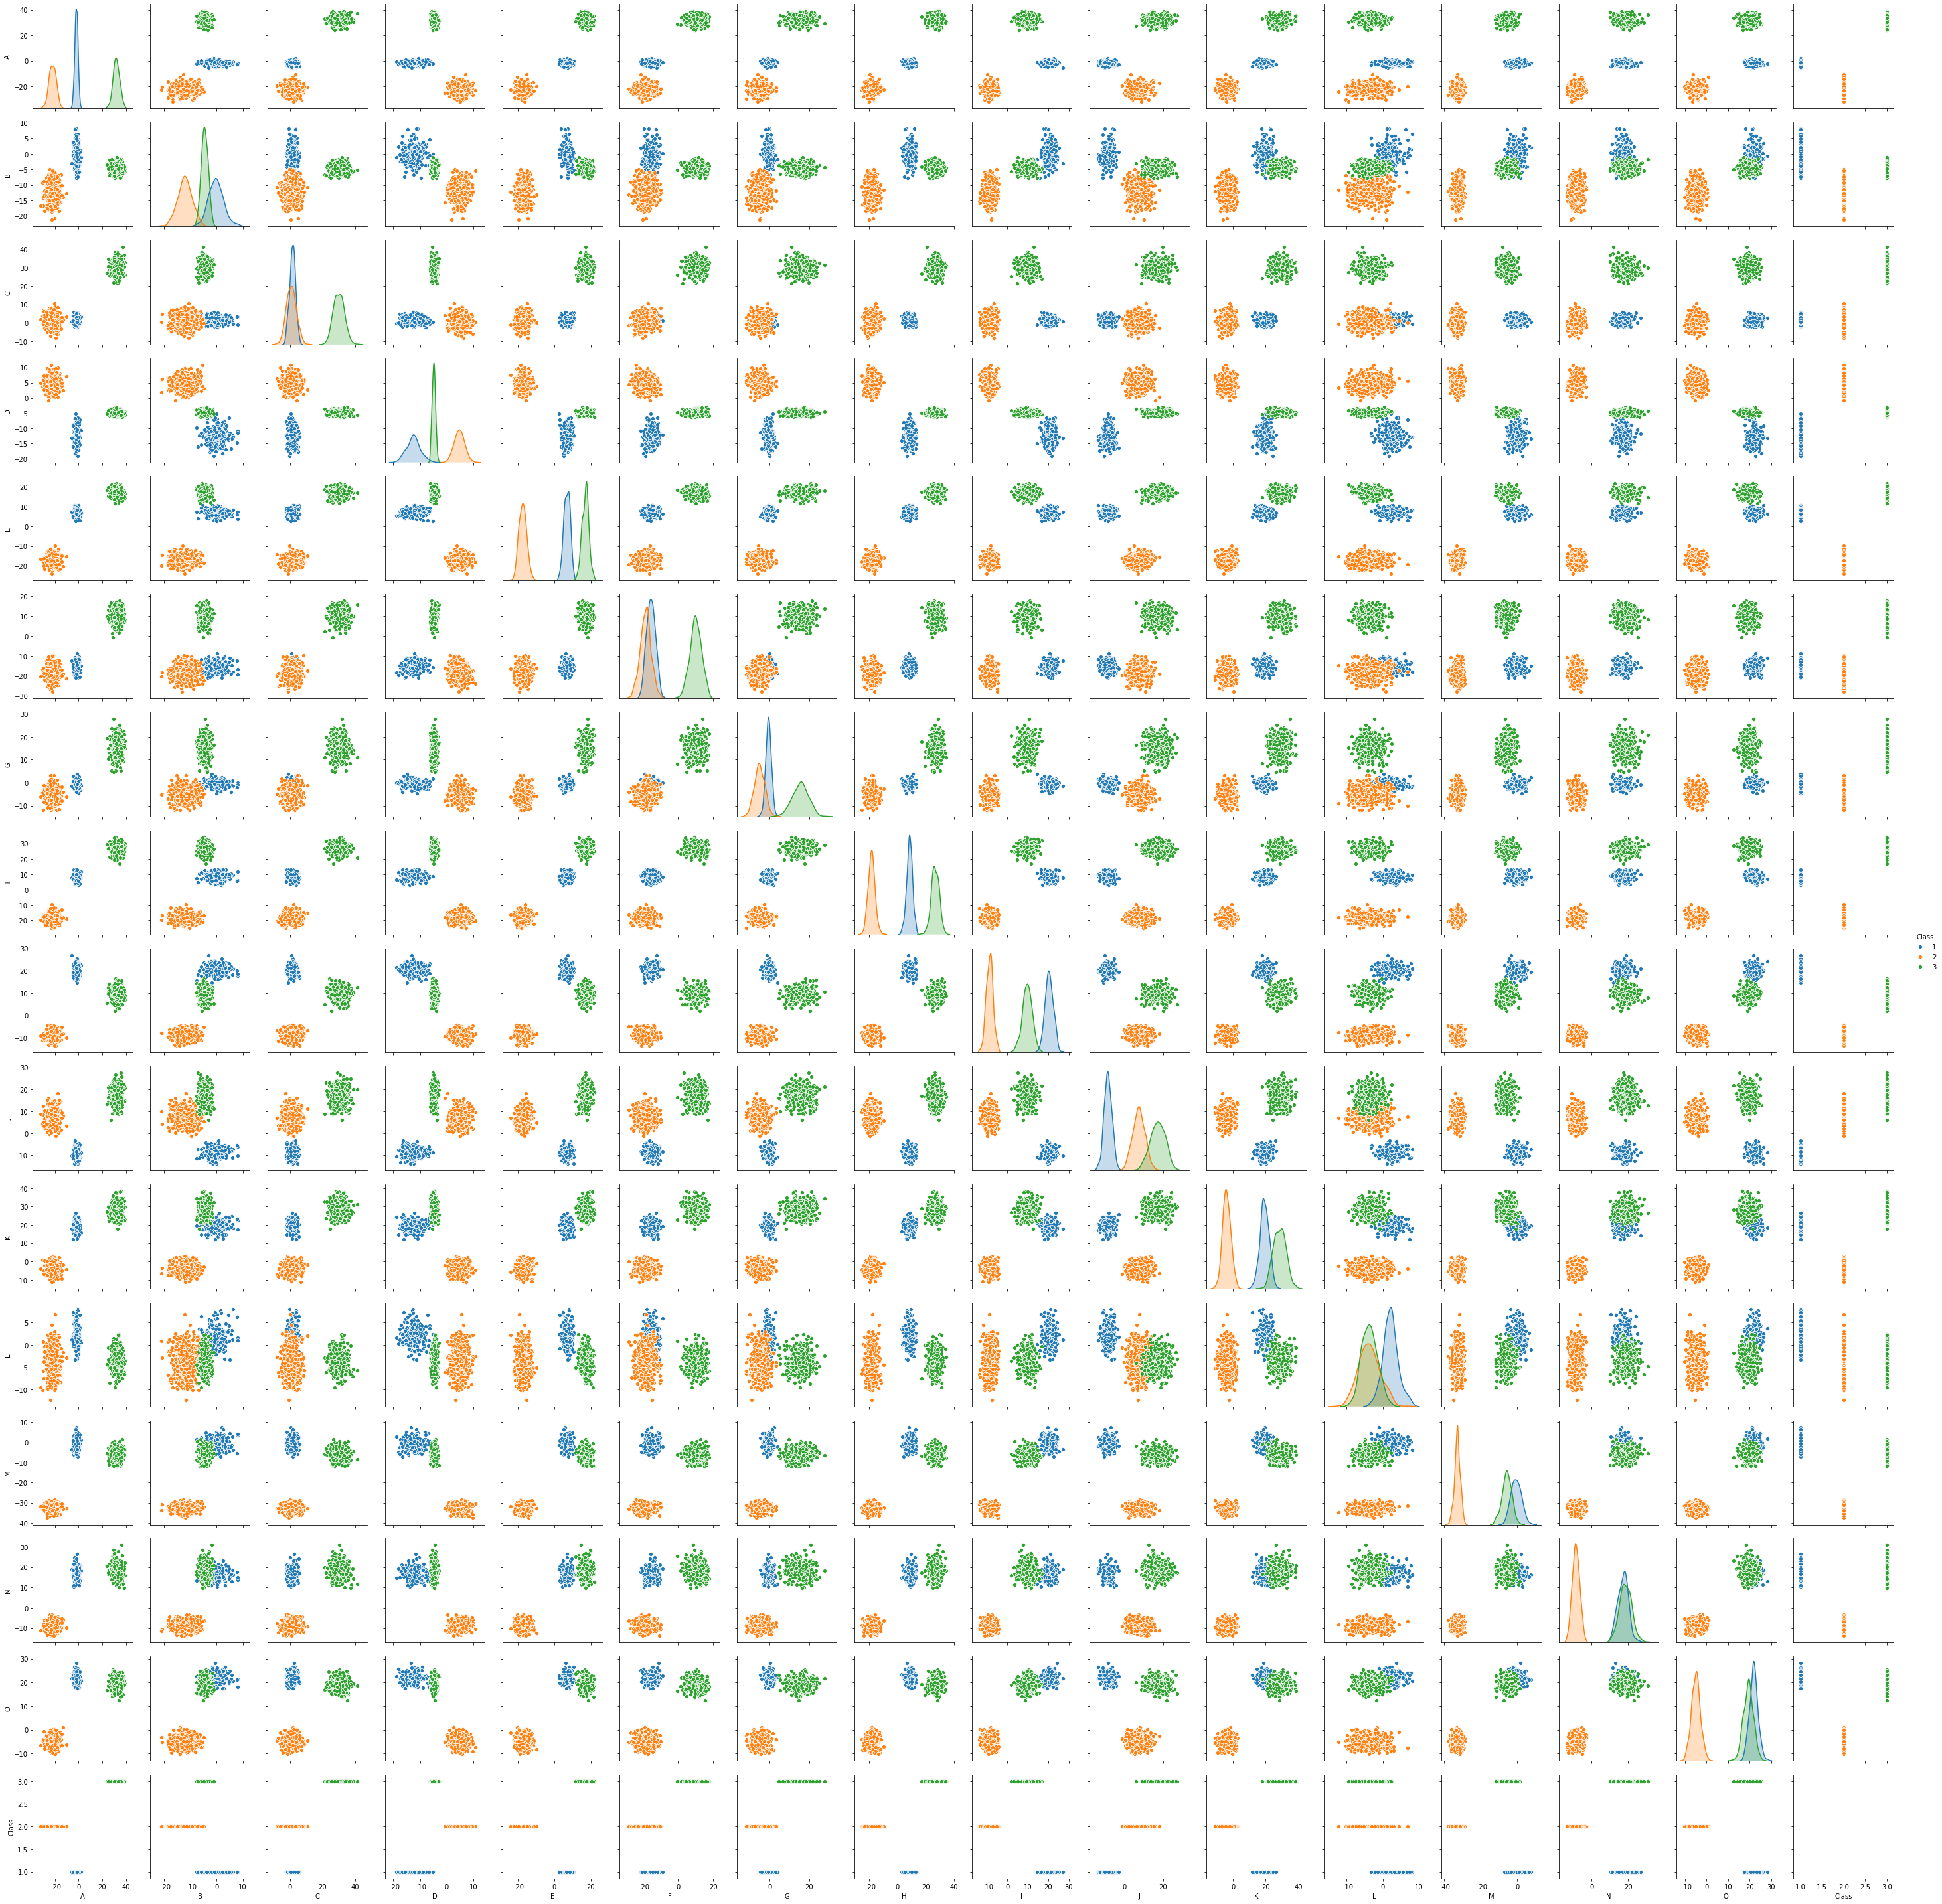

In [10]:
# A sample of the data has been taken because visualizing all the data won't be feasible 
fig = sns.pairplot(data.sample(1000), hue = 'Class')
fig
#fig.savefig('D://Data Science/Data Science 2nd Sem/Data Mining/Pairplot.png', format = 'png', dpi = 600)

### Fitting an initial test model with all the features of the dataset

In [6]:
#Initial Train-Test split for model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123)
Logit = LogisticRegression(solver = 'lbfgs')
Logit.fit(X_train, y_train)
y_pred_logit = Logit.predict(X_test)

print(classification_report(y_test, y_pred_logit)) 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     39847
           2       1.00      1.00      1.00    120078
           3       1.00      1.00      1.00     80075

    accuracy                           1.00    240000
   macro avg       1.00      1.00      1.00    240000
weighted avg       1.00      1.00      1.00    240000



We get an accuracy of 100% with the simplest possible classification model. This shows us that using all the feeatures to build a model would definitely lead to overfitting and the model would not be able to generalize well. That means that it would perform terribly with out-of-sample data. 
There is a need of analysis of the features here to build a more realistic model. 

### Correlation Matrix of the Features

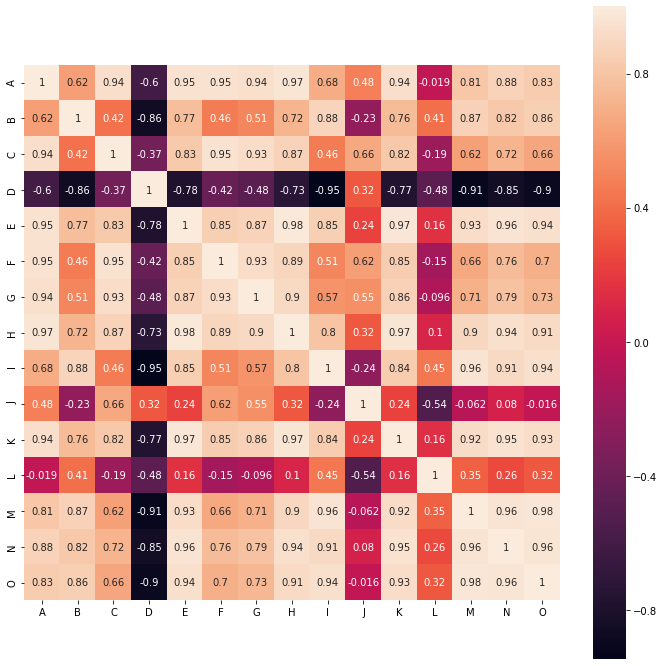

In [5]:
corrMatt = X.corr()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(corrMatt, annot = True, annot_kws={"size": 10}, square = True, ax=ax)
#fig.savefig('D://Data Science/Data Science 2nd Sem/Data Mining/CorrMatt.png', format = 'png', dpi = 1200)

We can conclude from the above matrix that the following pairs are the highly correlated features :
1. (A, H)
2. (A, E)
3. (D, I)
4. (E, H)
5. (M, O)
6. (C, F)
7. (K, H)
8. (N, O)

We can furthur examine the empirical distributions of the features to support these claims. 

### Visualizing feature distributions

<Figure size 432x288 with 0 Axes>

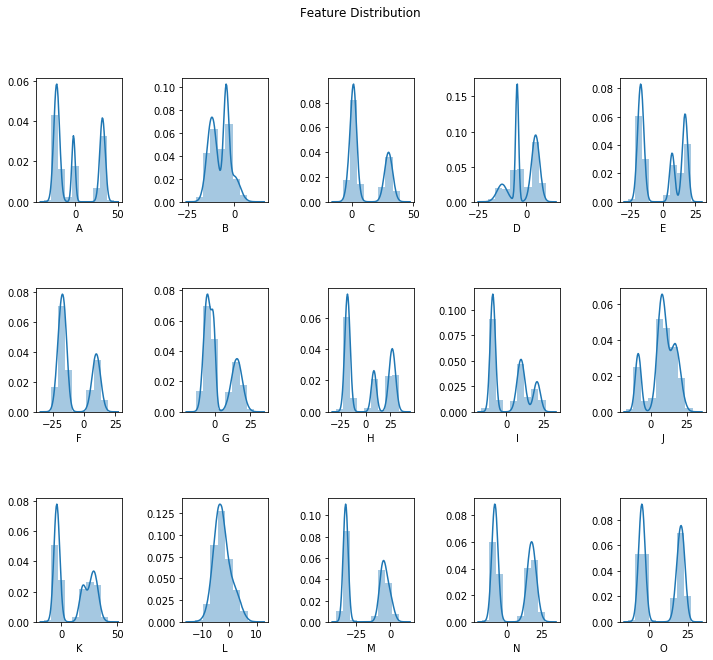

In [22]:
cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']

plt.figure()
fig, ax = plt.subplots(3,5, figsize = (12,10))
fig.subplots_adjust(hspace = 0.7, wspace = 0.7)
plt.suptitle('Feature Distribution')
for i in range(0,3):
    for j in range(0,5):
        if i == 0:
            sns.distplot(data[cols[i+j]], bins = 10, ax = ax[i][j])
        elif i == 1:
            sns.distplot(data[cols[i+j+4]], bins = 10, ax = ax[i][j])
        else:
            sns.distplot(data[cols[i+j+8]], bins = 10, ax = ax[i][j])
#fig.savefig('D://Data Science/Data Science 2nd Sem/Data Mining/FeatureDist.png', format = 'png', dpi = 1200) 

From the visual analysis we can group the similar features as: 
1. (A, E, H)
2. (D, I)
3. (K, H)
4. (C, F)
5. (N, O)

The rest of the features are their own group and are different from the rest.
Highly correlated features adds to the redundancy which would in turn add to overfitting the model.
We can remove the redundant features and try to fit the model with far lesser number of features.

Now that we have found out the highly correlated features, we can start testing models by discarding the redundant features. 

### Normalizing/Scaling the Data 

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Principal Component Analysis - Scree Plot to find optimal PCs
In this step we would find out the number of optimal Principal Components to be used throughout the modelling process.

[https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA]

[0.86268196 0.10791724 0.00328488 0.00310746 0.00305648 0.00287975
 0.0027037  0.00237806 0.00223939 0.00212034 0.00195871 0.00152986
 0.00146168 0.00145054 0.00122995]


Text(0, 0.5, 'Cumulative Explained Variance')

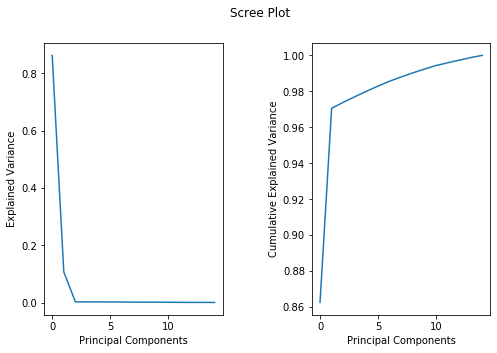

In [23]:
pca = PCA(random_state = 123)
PC = pca.fit_transform(X) 
print(pca.explained_variance_ratio_)
plt.figure(figsize = (8,5))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
plt.suptitle('Scree Plot')
plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.subplot(1,2,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
# plt.savefig('D://Data Science/Data Science 2nd Sem/Data Mining/ScreePlot.png', format = 'png', dpi = 1200)

#### We will be using 1 Principal Component. It captures 86% variance and hence would prevent overfitting

### Manual feature selection and Pipeline Trial
Let us try out a pipeline by choosing the features we can select after correlation analysis and visual inspection
#### I will be using Random Forest Classifier for the classification modelling throughout the rest of the project.
[https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier]

In [26]:
# Train-test split for pipeline building
# We will be using 1000 points for pipeline testing because a general 80-20 split results in an error while predicting.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
selected_cols1 = ['A', 'B', 'C', 'D', 'G', 'J', 'K', 'L', 'M', 'N']
test_pipeline1 = PMMLPipeline([
    ('mapper',
     DataFrameMapper([
         (X_train[selected_cols1].columns.values,
          [SimpleImputer(strategy = 'median'),
           StandardScaler()])])),
    ('pca', PCA(n_components=1)),
    ('classifier', RandomForestClassifier(max_depth = 3, n_estimators = 10))
])
    
# Fitting the pipeline with the training data
test_pipeline1.fit(X_train, y_train)

# Testing the pipeline by feeding it the test data
predict1 = test_pipeline1.predict(X_test)
print(accuracy_score(y_test, predict1))

0.9985958333333333


We can see that the accuracy still comes out pretty high after removing 5 redundant features.
The model is still over-fitting.



### Tree-Based Feature Selection
To furthur facilitate feature selection let us move on from manual methods and find out the FEATURE IMPORTANCES.
Since I will be using RandomForest Classifier for the rest of the classification jobs, I would use Tree Based Feature selection. 
The sklearn.emsemble package has a function ExtraTreesClassfier which will be used here. 

[https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassif]

[https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html]

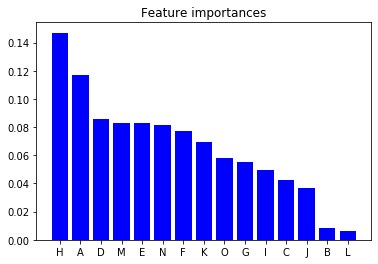

In [22]:
cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
feature_importances = clf.feature_importances_
# Sorting the columns according to their importances 
indices = np.argsort(feature_importances)[::-1]
sorted_cols = []
for i in indices:
    sorted_cols.append(cols[i])

# Plotting the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), feature_importances[indices], color="blue", align="center")
plt.xticks(range(X.shape[1]), sorted_cols)
plt.show()


Though the importance of the features do not dramatically drop off as we expect, but we have to eliminate more features to prevent overfitting and make the model more generalizable. 
During our manual analysis we dropped feature 'H' altogether due to it's high correlation with multiple features. But this plot shows that this is the most important feature. We have also included 'K', 'B', 'C', 'G' in our model which seems to possess very low importace. 

### Pipeline Trial with the 3 most important features ['H', 'A', 'D']
 

We will use all the possible subsets of these 3 features to train the pipeline. 

##### [--- This section of the code has been referenced from the example project given on Blackboard. Credits - Victoria Belotti ---]

In [28]:
selected_cols2 = [['A'],['D'],['H'],['A','D'],['A','H'],['D','H'],['A','D','H']]

for cols in selected_cols2:
    test_pipeline2 = PMMLPipeline([
            ('mapper',
             DataFrameMapper([
             (X_train[cols].columns.values,
             [StandardScaler()])])),
             ('pca',
             PCA(n_components=1)),
             ('classifier',
             RandomForestClassifier(max_depth = 3, n_estimators = 10))
    ])

    test_pipeline2.fit(X_train,y_train)
    pred = test_pipeline2.predict(X_test)
    print('Feature(s) tested:',cols, 'Accuracy:', accuracy_score(y_test, pred))


Feature(s) tested: ['A'] Accuracy: 0.9999958333333333
Feature(s) tested: ['D'] Accuracy: 0.9970833333333333
Feature(s) tested: ['H'] Accuracy: 0.9999
Feature(s) tested: ['A', 'D'] Accuracy: 0.9115791666666667
Feature(s) tested: ['A', 'H'] Accuracy: 1.0
Feature(s) tested: ['D', 'H'] Accuracy: 0.8964958333333334
Feature(s) tested: ['A', 'D', 'H'] Accuracy: 0.9962833333333333


We see here that the only combination of features that would prevent overfitting are ['A', 'D'] and ['D', 'H']. Hence, the feature selection process is almost comimg to an end.

So, the next step would be testing out the pipelines using these features. We will use cross-validation for this purpose.

### Pipeline Cross-Validation

[https://scikit-learn.org/stable/modules/cross_validation.html]

In [42]:
test_pipeline_cv1 = PMMLPipeline([
            ('mapper',
             DataFrameMapper([
             (X_train[['A', 'D']].columns.values,
             [StandardScaler()])])),
             ('pca',
             PCA(n_components=1)),
             ('classifier',
             RandomForestClassifier(max_depth = 3, n_estimators = 10))
])

cross_validate(test_pipeline_cv1, X, y, cv = 10, return_train_score = True)


{'fit_time': array([15.70810771, 15.59101939, 15.76756096, 15.58016586, 15.4190774 ,
        15.79434776,  9.44094491,  7.16408777,  6.86157227,  6.65547967]),
 'score_time': array([0.20744634, 0.21301126, 0.20932865, 0.20886064, 0.2169981 ,
        0.21451402, 0.08698082, 0.08608961, 0.08573842, 0.08408737]),
 'test_score': array([0.9118    , 0.91245833, 0.91134167, 0.91180833, 0.91241667,
        0.91099167, 0.9116    , 0.911075  , 0.91156667, 0.91200833]),
 'train_score': array([0.91177778, 0.91170926, 0.91166111, 0.91176944, 0.91171111,
        0.91184722, 0.91178796, 0.91179722, 0.91180185, 0.91174444])}

In [43]:
test_pipeline_cv2 = PMMLPipeline([
            ('mapper',
             DataFrameMapper([
             (X_train[['D', 'H']].columns.values,
             [StandardScaler()])])),
             ('pca',
             PCA(n_components=1)),
             ('classifier',
             RandomForestClassifier(max_depth = 3, n_estimators = 10))
])

cross_validate(test_pipeline_cv2, X, y, cv = 10, return_train_score = True)

{'fit_time': array([6.74743462, 6.25184417, 6.50160336, 6.20021796, 6.42487121,
        6.33571911, 6.14676499, 6.51399541, 6.43579745, 6.32519531]),
 'score_time': array([0.07982111, 0.09033751, 0.07783771, 0.07782769, 0.083776  ,
        0.08602023, 0.07488823, 0.07572293, 0.07676268, 0.07600164]),
 'test_score': array([0.895775  , 0.89495833, 0.89755   , 0.89643333, 0.89520833,
        0.89728333, 0.8962    , 0.896525  , 0.8967    , 0.89603333]),
 'train_score': array([0.89637963, 0.89642593, 0.89603241, 0.89660463, 0.89627963,
        0.89623241, 0.89634722, 0.89660556, 0.89660463, 0.89633333])}

#### From the cross-validated test scores obtained above we can conclude that both the feature sets gives us high accuracy without the possibility of over-fitting. I would choose the feature set ['A', 'D'] because it's performance is about 2% better than the other set.

### Selecting optimal Classifier Parameters

For this purpose we will use the sklearn.model_selection funtion GridSearchCV. 

[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV]

In [70]:
cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc = pd.DataFrame(X_sc, columns = cols)
X_train_sc, X_test_sc, y_train, y_test = train_test_split(X_sc, y, test_size = 0.2)
pca = PCA(n_components = 1)
pca.fit(X_train_sc[['A', 'D']])
X_train_pc = pca.transform(X_train_sc[['A', 'D']])
X_test_pc = pca.transform(X_test_sc[['A', 'D']])

#### Optimal Depth of trees in the forest

In [75]:
forest = RandomForestClassifier(n_estimators = 10)
parameter = {'max_depth': [1,2,4,6,8]}
gridForest = GridSearchCV(forest, param_grid = parameter, cv = 10, verbose = 1, n_jobs = -1)
gridForest.fit(X_train_pc, y_train).cv_results_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


{'mean_fit_time': array([ 5.08304937,  6.57143402,  9.20759044, 11.75464213, 12.80714881]),
 'std_fit_time': array([0.13144091, 0.22233006, 0.19660812, 0.15439158, 1.66277243]),
 'mean_score_time': array([0.1052186 , 0.09549558, 0.09594624, 0.10502167, 0.09105408]),
 'std_score_time': array([0.01642552, 0.00951193, 0.00907754, 0.00932496, 0.01937005]),
 'param_max_depth': masked_array(data=[1, 2, 4, 6, 8],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1},
  {'max_depth': 2},
  {'max_depth': 4},
  {'max_depth': 6},
  {'max_depth': 8}],
 'split0_test_score': array([0.83328125, 0.907125  , 0.913375  , 0.91359375, 0.91360417]),
 'split1_test_score': array([0.83328125, 0.90471875, 0.91116667, 0.91141667, 0.91144792]),
 'split2_test_score': array([0.83328125, 0.90397917, 0.90989583, 0.910625  , 0.91069792]),
 'split3_test_score': array([0.83328125, 0.90634375, 0.91225   , 0.912375  , 0.91229167]),
 'split

#### From the above results we can check the mean_test_score to and see that tree depth of 3 reaches an accuracy of 91% and then there's no substantial gain in accuracy by increasing depth. 
The time taken by GridSearchCV to output the results depends on the number of folds of CV and the parameters set. 

#### Determining optimal number of trees in the Forest

In [76]:
forest = RandomForestClassifier(max_depth = 3)
parameter = {'n_estimators': [10,50,100,150,200]}
gridForest = GridSearchCV(forest, param_grid = parameter, cv = 5, verbose = 1, n_jobs = -1)
gridForest.fit(X_train_pc, y_train).cv_results_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.1min finished


{'mean_fit_time': array([  6.87706285,  34.200705  ,  69.77230902, 102.6157968 ,
        113.47730079]),
 'std_fit_time': array([ 0.06617212,  0.28168094,  1.00541921,  0.92165814, 11.11098613]),
 'mean_score_time': array([0.22441239, 1.02467403, 2.00984545, 2.87672496, 2.56747985]),
 'std_score_time': array([0.02497624, 0.04578054, 0.06664479, 0.221837  , 0.2741038 ]),
 'param_n_estimators': masked_array(data=[10, 50, 100, 150, 200],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 150},
  {'n_estimators': 200}],
 'split0_test_score': array([0.91217708, 0.91217187, 0.9121875 , 0.9121875 , 0.91218229]),
 'split1_test_score': array([0.9110625 , 0.91104688, 0.91105208, 0.91104688, 0.91104688]),
 'split2_test_score': array([0.91263021, 0.91267708, 0.91264062, 0.91263542, 0.91265625]),
 'split3_test_score': array([0.91076563, 0.910

#### From the above results we can see that the number of trees doesn't make much of a difference to the accuracy score. For simplicity of the model I can choose 10 estimators but just to avoid under-fittting on larger datasets I would choose 50 because it doesn't display any substantial over-fitting phenomenon. 


#### Hence, we have determined the optimal hyperparameters for the final model fitting. 

### Machine Learning Pipelines - Final Build

#### PMML Pipeline

In [82]:
final_pipeline_pmml = PMMLPipeline([
    ('mapper',
     DataFrameMapper([
         (X[['A', 'D']].columns.values,
          [SimpleImputer(strategy = 'median'),
           StandardScaler()])])),
    ('pca', PCA(n_components=1)),
    ('classifier', RandomForestClassifier(n_estimators=50, max_depth=3))
])
    
cross_validate(final_pipeline_pmml, X, y, cv = 5, verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.1s remaining:   54.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.6s finished


{'fit_time': array([34.85999489, 34.66406751, 34.87120032, 35.48423362, 34.96664453]),
 'score_time': array([1.02435493, 1.02798581, 1.00321031, 0.8789494 , 1.00165749]),
 'test_score': array([0.91215833, 0.91163333, 0.9116875 , 0.9114375 , 0.91179167])}

In [83]:
# Fitting the pipeline with the whole dataset
final_pipeline_pmml.fit(X, y)

PMMLPipeline(steps=[('mapper', DataFrameMapper(default=False, df_out=False,
                features=[(array(['A', 'D'], dtype=object),
                           [SimpleImputer(add_indicator=False, copy=True,
                                          fill_value=None, missing_values=nan,
                                          strategy='median', verbose=0),
                            StandardScaler(copy=True, with_mean=True,
                                           with_std=True)])],
                input_df=False, sparse=False)),
       ('pca', PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
       ('classifier', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
               

#### Converting and saving the pipeline to .pmml format 

In [95]:
sklearn2pmml(final_pipeline_pmml,
             'D://DataScience/2ndSem/Data Mining/Project/Project_PMML_pipeline.pmml',
             with_repr = True)

#### ONNX Pipeline

In [86]:
# Creating an sklearn PMML Pipeline to be converted into an ONNX pipeline
''' DataFrameMapper does not work while converting to ONNX format. So we use ColumnTransformer from sklearn.compose
    for the imputation and scaling purposes 
'''

column_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler()) 
])
preprocessor = ColumnTransformer(transformers=[
        ('feature', column_transformer, ['A', 'D'])
]) 

final_pipeline_onnx = Pipeline([
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components = 1)),
            ('classifier', RandomForestClassifier(n_estimators=50, max_depth=3))
])    

cross_validate(final_pipeline_onnx, X, y, cv = 5, verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   37.9s remaining:   56.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished


{'fit_time': array([35.6108582 , 35.58293247, 35.51112556, 36.58625102, 35.32446003]),
 'score_time': array([1.00730634, 0.99744534, 1.04631376, 0.7733202 , 1.02392054]),
 'test_score': array([0.91215833, 0.91162917, 0.91168333, 0.9114    , 0.91180417])}

In [87]:
final_pipeline_onnx.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('feature',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                         

In [94]:
''' ONNX pipeline needs the input data as a list of tuples containing the features 
    and their types defined in data_types.py
'''
inputs_onnx_train = dict([(x, FloatTensorType([None, 1])) for x in X[['A', 'D']].columns.values])

# Converting the sklearn pipeline and saving it to .onnx format
try:
    model_onnx = convert_sklearn(final_pipeline_onnx,
                                 'pipeline_project_onnx',
                                initial_types=list(inputs_onnx_train.items()))
except Exception as e:
    print(e)

with open("D://DataScience/2ndSem/Data Mining/Project/Project_ONNX_pipeline.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())


### Visualizing the ONNX Pipeline - PyDot Graph

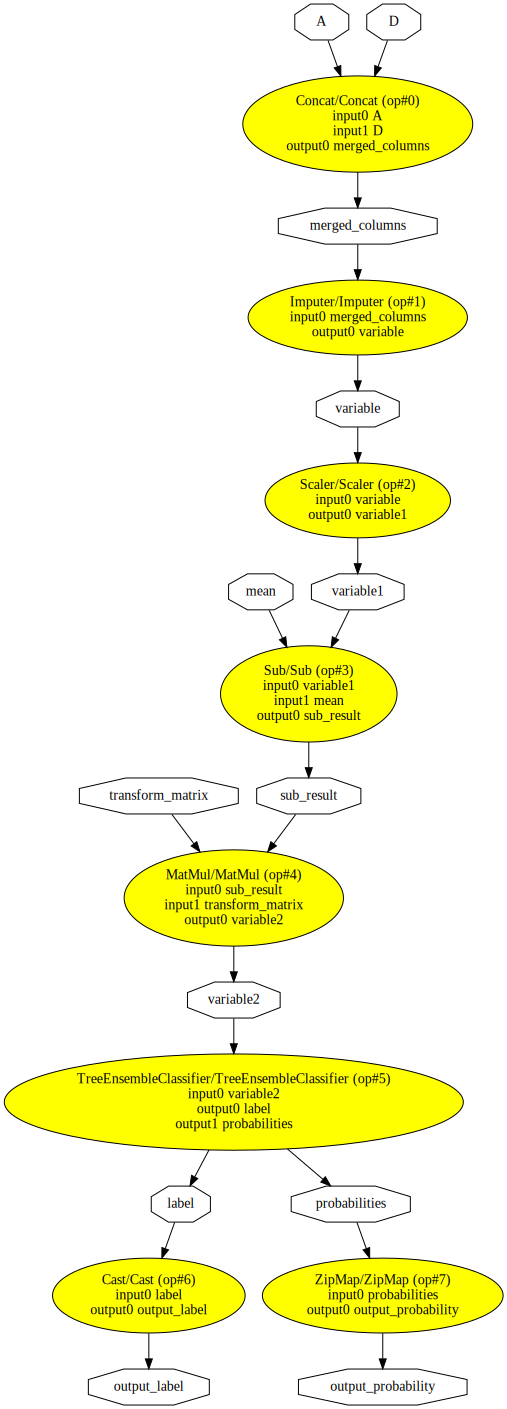

In [93]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="black",
                                                            fillcolor="yellow",
                                                            style="filled"))

gv = graphviz.Source(pydot_graph)
gv
#gv.render('D://DataScience/2ndSem/Data Mining/Project/pydot_graph.dot')
#graphviz.render('dot', 'png', 'D://DataScience/2ndSem/Data Mining/Project/pydot_graph.dot')

### Conclusion:
The primary thing I have understood from this project is that scaling down data to make a model generalize well is a lot more tedious than any other job as an analyst. The whole process might look linear and smooth but it consists of a huge deal of trial and error. This exercise has aquainted me with very essential data analysis and model selection packages and methods I have never used before. I have barely used the sklearn.model_selection package before but this project gave me an opportunity to explore it furthur. I have also learnt the beauty of a pipeline and what must be going behind putting a machine learning model to production in real life. It took me some time to grasp the functionalities of the pipelines at first, but I feel more comfortable with them now. 


### REFERENCES:

1. https://scikit-learn.org/stable/glossary.html#
2. https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0
3. https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
4. https://realpython.com/python-matplotlib-guide/
5. https://docs.scipy.org/doc/scipy/reference/stats.html#summary-statistics
6. https://stackoverflow.com/questions/48387389/save-graphviz-source-to-dot-file-using-python
7. http://onnx.ai/sklearn-onnx/auto_examples/plot_pipeline.html
8. https://medium.com/@xiaowei_6531/putting-sci-kit-learn-models-into-production-with-pmml-1d17b5fc8123